In [1]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['image.origin'] = 'lower'
#plt.rcParams.update({'font.size': 17})

SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def savefig(filename):
    plt.savefig("plots/"+filename, dpi=70, bbox_inches = 'tight', pad_inches = 0.1)

In [2]:
from astropy.nddata import CCDData, Cutout2D
from astropy.io import fits 
from astropy import units as u 

url = 'https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0/hlsp_frontier_hst_wfc3-60mas_abell2744_f105w_v1.0_drz.fits'

image_data = CCDData.read(url, cache=True)
rms_data = fits.getdata(url.replace('drz', 'rms'))

In [3]:
from astropy.coordinates import SkyCoord

targ_x, targ_y = image_data.wcs.world_to_pixel(SkyCoord(3.596248*u.deg,  -30.388517*u.deg))

In [4]:
from astropy import units as u 

image = Cutout2D(image_data, position=(targ_x-1, targ_y), size=150, copy=True, wcs=image_data.wcs)
rms =  Cutout2D(rms_data, position=(targ_x-1, targ_y), size=150, copy=True)

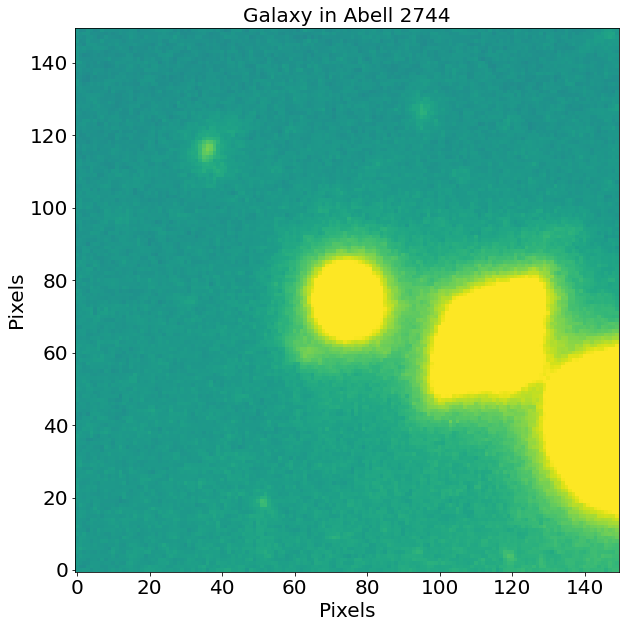

In [5]:
import numpy as np


vmax = 0.05 # Use the image std as max and min of all plots 
vmin = - vmax 

plt.imshow(image.data, vmin=vmin, vmax=vmax)
plt.title("Galaxy in Abell 2744")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

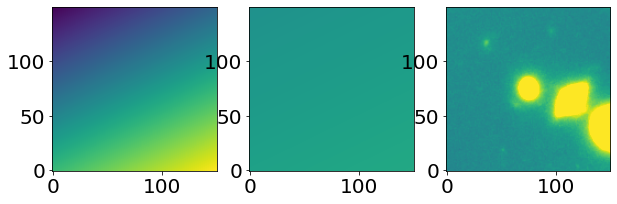

In [6]:
from petrofit.fitting import fit_background
import numpy as np 

def calc_bg(target_image):
    fig, axs = plt.subplots(1,3)
    x_arr = np.linspace(0, target_cutout_size, target_cutout_size+1)[:-1]
    x_grid, y_grid = np.meshgrid(x_arr, x_arr)
    
    bg_image = fit_background(target_image, sigma=3.0)[0](x_grid, y_grid)
    
    plt.sca(axs[0])
    plt.imshow(bg_image)
    
    plt.sca(axs[1])
    plt.imshow(bg_image, vmax=vmax, vmin=vmin)
    
    plt.sca(axs[2])
    plt.imshow(target_image-bg_image, vmax=vmax, vmin=vmin)
    
    return bg_image

target_cutout_size = len(image.data)
bg = calc_bg(image.data)
image.data = image.data - bg 

## Make Source Catalog 

We will use the sigma clipped std as a threshold at the segmentation and deblending steps.


In [7]:
from astropy.stats import sigma_clipped_stats
image_mean, image_median, image_stddev = sigma_clipped_stats(image.data, sigma=3)

Here we identity sources in the input image.

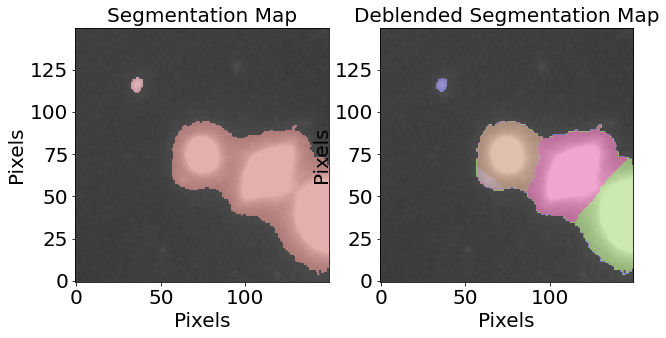

Num of Targets: 5


In [8]:
from petrofit.segmentation import make_catalog, plot_segments

threshold = image_stddev * 2

# Define smoothing kernel
kernel_size = 3
fwhm = 3

# Min Source size (area)
npixels = 2**2


cat, segm, segm_deblend = make_catalog(    
    image.data, 
    threshold=threshold, 
    deblend=True,                 
    kernel_size=kernel_size,                  
    fwhm=fwhm, 
    npixels=npixels,
    contrast=0.00,
    plot=True, vmax=vmax, vmin=vmin
)

plt.show()

# Display source properties
print("Num of Targets:", len(cat))

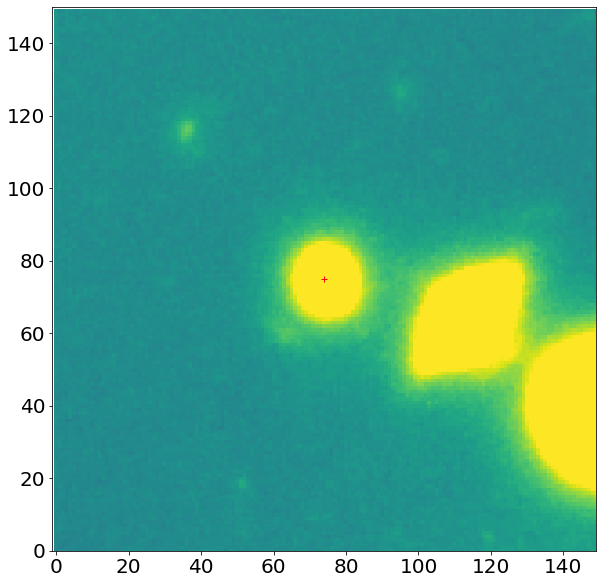

In [9]:
from petrofit.photometry import order_cat
from petrofit.utils import plot_target
# Sort and select object of interest in the catalog
sorted_idx_list = order_cat(cat, key='area', reverse=True)
idx = sorted_idx_list[2] # index 0 is largest 
source = cat[idx]  # get source from the catalog 

plot_target(
    position=(source.maxval_xindex, source.maxval_yindex), 
    image=image.data, 
    size=max(image.data.shape)//2, 
    vmax=vmax, 
    vmin=vmin
)

# PSF

PSF Shape = (51, 51)


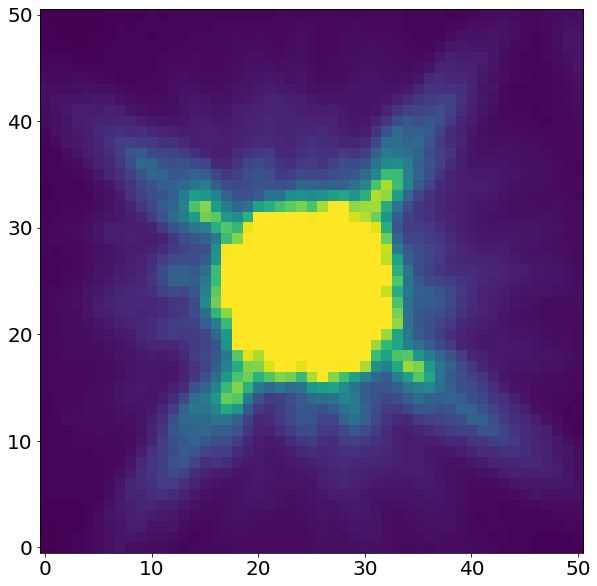

In [10]:
from astropy.io import fits

# Load PSF image (2D array)
PSF = fits.getdata('f105w_psf.fits.gz')

# Normalize PSF 
PSF = PSF / PSF.sum()

# Note that the PSF shape is odd on all sides
print("PSF Shape = {}".format(PSF.shape))

# Plot PSF and use vmax and vmin to show difraction spikes
plt.imshow(PSF, vmin=0, vmax=PSF.std()/10)
plt.show()

## StatMorph

In [11]:
image_data.header['BUNIT']

'ELECTRONS/S'

In [12]:
image_data.header['EXPTIME']

68952.38409499997

In [13]:
gain = image_data.header['EXPTIME']
gain

68952.38409499997

We could not see the fitting time here (fitting in lazy property) so 
we had to insert a print statement in statmorph source to print out 
only fitting time (in seconds, time take right before fitting and right after):

`Line 2392 of statmorph.py`
```
t1 = time()
# Try to fit model
fit_sersic = fitting.LevMarLSQFitter()
sersic_model = fit_sersic(sersic_init, x, y, z, weights=fit_weights,
                          maxiter=self._sersic_maxiter, acc=1e-5)

print(self.label, 'time:', time()-t1)
```

In [14]:

import statmorph
source_morphs = statmorph.source_morphology(
    image.data, segm_deblend, gain=gain, psf=PSF)



3 time: 0.06352686882019043
4 time: 0.18652129173278809
5 time: 0.04920077323913574


In [15]:
morph = source_morphs[idx]

In [16]:
morph.label

5

In [23]:
from astropy.table import Table
rows = ['amplitude', 'r_eff', 'n', 'x_0', 'y_0', 'ellip', 'theta', 'r_petro', 'r_20', 'r_80', 'C2080', 'Total Flux']

sm_results = [morph.sersic_amplitude,  morph.sersic_rhalf,  morph.sersic_n,  morph.sersic_xc, morph.sersic_yc,  morph.sersic_ellip, morph.sersic_theta, morph.rpetro_ellip, morph.r20, morph.r80, morph.concentration, morph.flux_ellip,]

sm_results = [float('{:0.3f}'.format(i)) for i in sm_results]

t = Table(data=[rows, sm_results], names=['Values', 'statmorph'])
t

Values,statmorph
str10,float64
amplitude,0.088
r_eff,7.702
n,1.587
x_0,74.939
y_0,75.392
ellip,0.106
theta,1.977
r_petro,18.97
r_20,3.606


In [18]:
t.write('statmorph_abell2744.csv', overwrite=True)

In [19]:
from petrofit.photometry import flux_to_abmag
flux_to_abmag(float(morph.flux_ellip), image_data.header)

21.773565353790975

In [20]:
# snp = 100.0
# from astropy.visualization import simple_norm
# ny, nx = image.data.shape
# y, x = np.mgrid[0:ny, 0:nx]
# fitted_model = statmorph.ConvolvedSersic2D(
#     amplitude=morph.sersic_amplitude,
#     r_eff=morph.sersic_rhalf,
#     n=morph.sersic_n,
#     x_0=morph.sersic_xc,
#     y_0=morph.sersic_yc,
#     ellip=morph.sersic_ellip,
#     theta=morph.sersic_theta)
# fitted_model.set_psf(PSF)  # required when using ConvolvedSersic2D
# image_model = fitted_model(x, y)

# fig = plt.figure(figsize=(15,5))

# ax = fig.add_subplot(131)
# ax.imshow(image.data, cmap='gray', origin='lower', vmax=0.05)
#            #norm=simple_norm(image.data, stretch='log', log_a=10000))
# ax.set_title('Original image')

# ax = fig.add_subplot(132)
# ax.imshow(image_model, cmap='gray', origin='lower', vmax=0.05)
#           # norm=simple_norm(image.data, stretch='log', log_a=10000))
# ax.set_title('Fitted model')

# ax = fig.add_subplot(133)
# residual = image.data - image_model
# ax.imshow(residual, cmap='gray', origin='lower', vmax=0.05)
#          #  norm=simple_norm(residual, stretch='linear'))
# ax.set_title('Residual')

